# RB-Demo

In this demo, we illustrate some functions and results used in random benchmarking (RB) the behavior of the Starmon-5 machine.

### Set up environment

In [1]:
# Update kernel with source code
%reload_ext autoreload
%autoreload 2

In [2]:
# Import general functions
import time
import numpy as np
import pickle
import qiskit

# Import rb source code
from rb import *

### Load job results from previous experiments

For better demonstration purpose, we use the results that have been previously acquired from the Starmon-5 at around 10:00pm on Jan 29th (EST). Ten experiments generated from the same RB set-up are loaded below. 

In [3]:
# Load the previous job results
result_list = []
circ_list = []
for i in range(5):
    job = pickle.load(open('rb-data/single_qbt_job_lst%d.pickle' % i, 'rb'))
    circ = pickle.load(open('rb-data/single_qbt_circ_lst%d.pickle' % i, 'rb'))
    for j in job:
        result_list.append(j.result())
    for c in circ:
        circ_list.append(c)

In [4]:
# Recreate the RB set-up of the 10 experiments

# number of qubits intended for RB experiments
nQ = 5
# array of clifford lengths (i.e. number of clifford elements) to test in RB experiments
nCliffs = np.arange(1,200,20)
# list of qubit indices in simultaneous RB experiments
pattern = [[0], [1], [2], [3], [4]]
# list of integers for scaling nCliffs
length_multiplier = [3, 3, 3, 3, 3]
# number of shots per RB circuit
shots = 1024
# number of different circuits per RB configuration 
nSeeds = 2
# list of gates to decompose RB circuits in
basis_gates = ["rx", "ry"]
# each list in xdata specify a set of Clifford lengths 
# tested on the corresponding qubit(s) in RB
xdata = [nCliffs*3, nCliffs*3, nCliffs*3, nCliffs*3, nCliffs*3]

### Plot RB results

As shown below, results from the previous experiments are plotted using the fitting function from qiskit. Here, clifford length stands for the number of clifford elements tested in RB experiments. Ground state population is the state fidelity after action by a number of cliffords in the circuit. EPC is shortened for error per clifford. And $\alpha$ is a fitting parameter. 

More information regarding fitting maybe found on the <a href="https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html#simultaneousrb">qiskit</a> tutorial website.

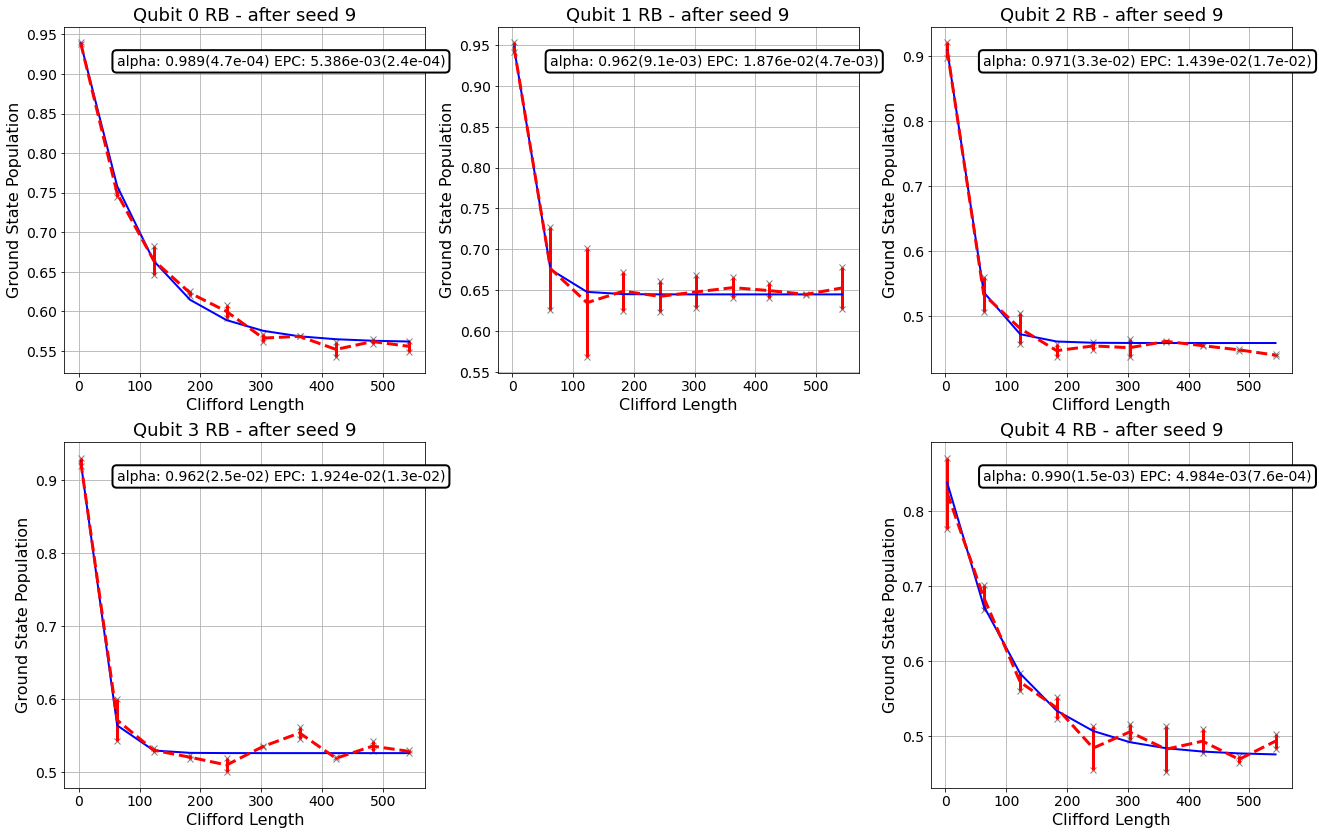

In [5]:
rb_data = plot_rb(result_list, pattern, xdata, savedata=True, savefig=False)

### Convert EPC to EPG for Starmon-5

Since RB is carried based on clifford elements and $Rx$ (rotation around $x-$axis) and $Ry$ (rotation around $y-$axis) gates are not necessarily clifford gates, we need to convert the EPC results from RB to error per gate (EPG) for different qubits to better understand the noise behavior of the machine.

The first step is to calculate the gate per clifford based on the compiled experiment circuits, shown as below

In [6]:
avg_gate_list = get_gate_num(circ_list, xdata, pattern, basis_gates)
print("\nAvg_gate_list:")
print(avg_gate_list)

Qubit(s): [0]
Number of rx gates per Clifford: 0.982737
Number of ry gates per Clifford: 0.831095
Qubit(s): [1]
Number of rx gates per Clifford: 0.998650
Number of ry gates per Clifford: 0.841715
Qubit(s): [2]
Number of rx gates per Clifford: 0.996387
Number of ry gates per Clifford: 0.841496
Qubit(s): [3]
Number of rx gates per Clifford: 0.991131
Number of ry gates per Clifford: 0.832774
Qubit(s): [4]
Number of rx gates per Clifford: 0.991241
Number of ry gates per Clifford: 0.821679

Avg_gate_list:
[{0: {'rx': 0.9827372262773723, 'ry': 0.8310948905109489}}, {1: {'rx': 0.9986496350364964, 'ry': 0.8417153284671532}}, {2: {'rx': 0.9963868613138687, 'ry': 0.8414963503649635}}, {3: {'rx': 0.9911313868613139, 'ry': 0.8327737226277372}}, {4: {'rx': 0.9912408759124087, 'ry': 0.8216788321167883}}]


Next, according to the general conversion <a href="https://qiskit.org/documentation/stubs/qiskit.ignis.verification.calculate_1q_epc.html">relation</a> between EPC and EPG below

$$
EPC = 1 - \Pi_{i} (1 - EPG_i)^{N_i}
$$

where $N_i$ is the number of gates per clifford, and the product is taken over all gates, we can explicitly write the EPC to EPG conversion for Starmon-5 as

$$
EPC = 1 - (1 - EPG_{rx})^{N_{rx}}(1 - EPG_{ry})^{N_{ry}}
$$

Since $Rx$ and $Ry$ are both orthogonal to the Z measurement basis and are both single qubit gates, we assume that the fidelity of $Rx$ and $Ry$ are close to each other and take $Rx = Ry$, which gives

$$
EPC = 1 - (1 - EPG_{rx})^{N_{rx}+N_{ry}} = 1 - (1 - EPG_{ry})^{N_{rx}+N_{ry}}
$$

And consequently,

$$
EPG_{rx} = EPG_{ry} = 1 - (1 - EPC)^{\frac{1}{(N_{rx}+N_{ry})}}
$$

Finally, we calculate EPG for qubit 0 to 5 in Starmon-5 according to the reasoning above.

In [7]:
nGate = []
for i in range(len(pattern)):
    num = 0
    to_add = avg_gate_list[i][i]
    for gate in to_add:
        num += to_add[gate]
    nGate.append(num)
nGate = np.array(nGate)
epc = np.array([qubit['epc'] for qubit in rb_data])
epg = 1 - (1 - epc)**(1/nGate)

for i in range(5):
    print("Error per single-qubit gate for q%d" % i, "is: {:.3%}".format(epg[i]))

Error per single-qubit gate for q0 is: 0.297%
Error per single-qubit gate for q1 is: 1.024%
Error per single-qubit gate for q2 is: 0.786%
Error per single-qubit gate for q3 is: 1.059%
Error per single-qubit gate for q4 is: 0.275%
